In [1]:
# do all imports
import pandas as pd
import os
import re
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode
import plotly.express as px
import plotly.graph_objects as go
import gtrend_tools
serpapi_api_key = "76f3ea1f6758054f7bb79457102d937bc1dff7ae4a1ecc98e6a5751530a11824"



In [2]:
# define function to load trend data and then load it
def combine_trend_files(directory, file_prefix):
    """
    Combines multiple CSV files with the same prefix into a single dataframe.
    
    Args:
        directory (str): Path to directory containing CSV files
        file_prefix (str): Prefix of files to combine
        
    Returns:
        pd.DataFrame: Combined dataframe with columns named by iteration
    """
    # Get all CSV files that start with the prefix
    files = [f for f in os.listdir(directory) 
             if f.startswith(file_prefix) and f.endswith('.csv')]

    # Sort files by their iteration number
    files.sort(key=lambda x: int(re.search(r'_i(\d+)\.csv$', x).group(1)))

    # Initialize an empty list to store dataframes
    dfs = []

    # Read each file and store in the list
    for file in files:
        # Extract the iteration number from the filename
        iter_num = re.search(r'_i(\d+)\.csv$', file).group(1)
        # Read the CSV file
        df = pd.read_csv(os.path.join(directory, file), index_col=0)
        # Rename the column to match the iteration number
        df.columns = [f"i{iter_num}"]
        dfs.append(df)

    # Combine all dataframes horizontally
    combined_df = pd.concat(dfs, axis=1)
    
    return combined_df

# set directory
directory = "./testdata"

# first search term
# file_prefix_1 = "artificial_intelligence"
# combined_df_1 = combine_trend_files(directory, file_prefix_1)
# print(f"Processed files with prefix '{file_prefix_1}'")
# print(f"Shape: {combined_df_1.shape}")

# second search term
file_prefix_2 = "bathroom_bill"
combined_df_2 = combine_trend_files(directory, file_prefix_2)
print(f"Processed files with prefix '{file_prefix_2}'")
print(f"Shape: {combined_df_2.shape}")

# third search term
# file_prefix_3 = "qanon"
# combined_df_3 = combine_trend_files(directory, file_prefix_3)
# print(f"Processed files with prefix '{file_prefix_3}'")
# print(f"Shape: {combined_df_3.shape}")


Processed files with prefix 'bathroom_bill'
Shape: (204, 330)


In [33]:
# define function to plot stacked histograms in 3D with flat 2d layers in stack. Uses matplotlib.
def plot_stacked_histograms_3d_thin_matplotlib(df, bins=20, hist_range=None, colors=None, alpha=0.8, figsize=(12, 8), title=None, normalize=None, ignore_constant=False):
    """
    Plots a stacked 3D histogram, one per row of the DataFrame.
    
    Parameters:
        df (pd.DataFrame): Each row is a separate histogram.
        bins (int): Number of bins for the histograms.
        hist_range (tuple): Range for the histograms (min, max).
        colors (list): List of colors for each histogram.
        alpha (float): Transparency of the bars.
        figsize (tuple): Figure size in inches (width, height).
        title (str): Title for the plot.
        normalize (str): Normalization method ('mode' or None).
        ignore_constant (bool): Whether to ignore constant rows.
        
    Returns:
        tuple: (fig, ax) The figure and axes objects
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    n_rows = df.shape[0]
    y_pos = np.arange(n_rows)
    
    if colors is None:
        # Generate colors if not provided
        colors = plt.cm.viridis(np.linspace(0, 1, n_rows))
    
    for i, (idx, row) in enumerate(df.iterrows()):
        data = row.values
        
        # Skip constant rows if ignore_constant is True
        if ignore_constant and len(np.unique(data)) == 1:
            continue
            
        # Normalize data if requested
        if normalize == "mode":
            mode_value = mode(data, keepdims=True)[0][0]
            data = data - mode_value
            
        hist, bins_edges = np.histogram(data, bins=bins, range=hist_range)
        xs = (bins_edges[:-1] + bins_edges[1:]) / 2
        ax.bar(xs, hist, zs=i, zdir='y', alpha=alpha, color=colors[i % len(colors)], label=str(idx))
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Row')
    ax.set_zlabel('Frequency')
    ax.set_yticks(y_pos)
    #ax.set_yticklabels(df.index)
    ax.set_yticklabels([])
    if title:
        ax.set_title(title)
    #plt.legend()
    
    return fig, ax

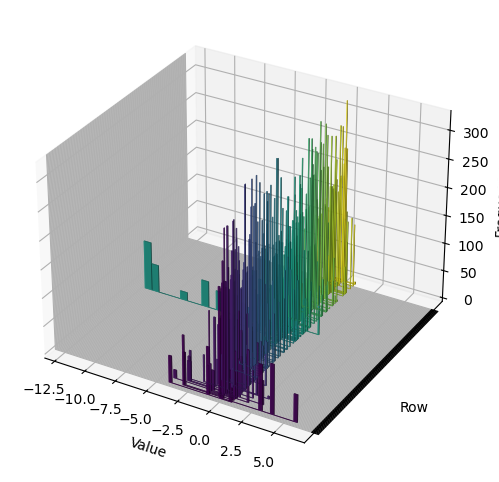

In [35]:
# Plot in 3d the variations across repeat searches for the second test dataset
fig, ax = plot_stacked_histograms_3d_thick_matplotlib(combined_df_2, figsize=(12, 6), normalize="mode", ignore_constant=True)
plt.show(block=True)

In [34]:
# define function to plot stacked histograms with thickness. Uses matplotlib.
def plot_stacked_histograms_3d_thick_matplotlib(
    df, bins=20, hist_range=None, colors=None, alpha=0.8, figsize=(12, 8), title=None, normalize=None, ignore_constant=False
):
    """
    Plots a stacked 3D histogram, one per row of the DataFrame, with thick bars.
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    n_rows = df.shape[0]
    y_pos = np.arange(n_rows)

    if colors is None:
        colors = plt.cm.viridis(np.linspace(0, 1, n_rows))

    for i, (idx, row) in enumerate(df.iterrows()):
        data = row.values

        if ignore_constant and len(np.unique(data)) == 1:
            continue

        if normalize == "mode":
            mode_value = mode(data, keepdims=True)[0][0]
            data = data - mode_value

        hist, bins_edges = np.histogram(data, bins=bins, range=hist_range)
        bin_width = bins_edges[1] - bins_edges[0]

        xs = bins_edges[:-1]  # left edge of each bin
        ys = np.full_like(xs, i, dtype=float)  # y-position for this row
        zs = np.zeros_like(xs)  # bars start at z=0

        dx = np.full_like(xs, bin_width)
        dy = np.full_like(xs, 1.0)  # so bars touch in y
        dz = hist

        ax.bar3d(xs, ys, zs, dx, dy, dz, color=colors[i % len(colors)], alpha=alpha, shade=True)

    ax.set_xlabel('Value')
    ax.set_ylabel('Row')
    ax.set_zlabel('Frequency')
    ax.set_yticks(y_pos)
    ax.set_yticklabels([])  # or use df.index if you want labels
    if title:
        ax.set_title(title)

    return fig, ax

In [36]:
# plot stacked histograms with vispy
def plot_stacked_histograms_3d_vispy(
    df, bins=20, hist_range=None, colors=None, figsize=(800, 600), title=None, normalize=None, ignore_constant=False
):
    """
    Plots a stacked 3D histogram, one per row of the DataFrame, with thick bars using Vispy.
    Returns the Vispy canvas.
    """
    n_rows = df.shape[0]
    y_pos = np.arange(n_rows)

    # Setup Vispy canvas and view
    canvas = scene.SceneCanvas(keys='interactive', size=figsize, show=True, bgcolor='white')
    view = canvas.central_widget.add_view()
    view.camera = 'turntable'
    view.camera.fov = 45
    view.camera.distance = 2.5 * max(n_rows, bins)

    # Color map
    if colors is None:
        cmap = color.get_colormap('viridis')
        print(cmap)
        colors = [cmap.map(np.array([i / max(n_rows-1, 1)]))[0] for i in range(n_rows)]
        print(colors)

    # Add boxes for each histogram
    for i, (idx, row) in enumerate(df.iterrows()):
        data = row.values

        if ignore_constant and len(np.unique(data)) == 1:
            continue

        if normalize == "mode":
            mode_value = mode(data, keepdims=True)[0][0]
            data = data - mode_value

        hist, bins_edges = np.histogram(data, bins=bins, range=hist_range)
        bin_width = bins_edges[1] - bins_edges[0]

        xs = bins_edges[:-1]  # left edge of each bin
        print(hist)
        for j, count in enumerate(hist):
            if count == 0:
                continue
            # Center of the box
            x = xs[j] + bin_width / 2
            y = i + 0.5  # center in the y "row"
            z = count / 2  # box is centered at half its height

            box = visuals.Box(
                width=bin_width,
                height=count,
                depth=1.0,
                color=colors[i],
                edge_color='black'
            )
            box.transform = scene.transforms.MatrixTransform()
            box.transform.translate((x, y, z))
            view.add(box)

    # Add axes
    axis = visuals.XYZAxis(parent=view.scene)
    if title:
        canvas.title = title

    return canvas

In [ ]:
# Plot in 3d the variations across repeat searches for the second test dataset
canvas = plot_stacked_histograms_3d(combined_df_2, figsize=(12, 6), normalize="mode", ignore_constant=True)
canvas.show()
if sys.flags.interactive == 0:
        print("Not interactive; running app.run()")
        app.run()

In [31]:
def plot_stacked_histograms_3d_plotly(df, figsize=(12, 6), normalize=None, ignore_constant=True, title=None):
    """
    Plot stacked histograms as a 3D surface using plotly.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe where each row represents a different histogram
    figsize : tuple
        Figure size (width, height) in inches
    normalize : str or None
        If "mode", normalize each histogram by subtracting its mode
    ignore_constant : bool
        If True, ignore rows that have constant values
    title : str or None
        Title for the plot
        
    Returns:
    --------
    plotly.graph_objects.Figure
        The plotly figure object
    """
    import plotly.graph_objects as go
    import numpy as np
    from scipy.stats import mode
    
    # Get data range for consistent binning
    all_data = df.values.flatten()
    hist_range = (np.min(all_data), np.max(all_data))
    print("hist_range: ", hist_range)
    bins = 50  # Number of bins
    
    # Create meshgrid for surface plot
    x = np.linspace(hist_range[0], hist_range[1], bins)
    y = np.arange(len(df.index))
    X, Y = np.meshgrid(x, y)
    
    # Initialize Z matrix
    Z = np.zeros((len(df.index), bins))
    
    # Generate colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(df.index)))
    
    # Calculate histograms for each row
    for i, idx in enumerate(df.index):
        data = df.loc[idx].values
        print(data)
        # Skip constant rows if requested
        if ignore_constant and np.all(data == data[0]):
            continue
            
        if normalize == "mode":
            mode_value = mode(data, keepdims=True)[0][0]
            print("Mode value: ", mode_value)
            data = data - mode_value
        print(data)
        hist, _ = np.histogram(data, bins=bins, range=hist_range)
        print(hist)
        Z[i, :] = hist
    
    # Create surface plot
    fig = go.Figure(data=[go.Surface(
        x=X,
        y=Y,
        z=Z,
        colorscale='Viridis',
        showscale=True,
        name='Histogram Surface'
    )])
    
    # Update layout
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='Value',
            yaxis_title='Row Index',
            zaxis_title='Count',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=figsize[0]*100,  # Convert inches to pixels
        height=figsize[1]*100
    )
    
    return fig


In [44]:
def plot_stacked_histograms_3d_thick_plotly(
    df, bins=20, hist_range=None, colors=None, alpha=0.8, figsize=(12, 8), title=None, normalize=None, ignore_constant=False
):
    """
    Plots a stacked 3D histogram, one per row of the DataFrame, using Plotly Surface.
    """
    n_rows = df.shape[0]
    
    if colors is None:
        colors = px.colors.sample_colorscale("viridis", n_rows)
    
    # Create figure
    fig = go.Figure()
    
    # Prepare data for surface plot
    X = np.linspace(hist_range[0] if hist_range else df.values.min(), 
                   hist_range[1] if hist_range else df.values.max(), 
                   bins)
    Y = np.arange(n_rows)
    Z = np.zeros((n_rows, bins))
    
    for i, (idx, row) in enumerate(df.iterrows()):
        data = row.values
        
        if ignore_constant and len(np.unique(data)) == 1:
            continue
            
        if normalize == "mode":
            mode_value = mode(data, keepdims=True)[0][0]
            data = data - mode_value
            
        hist, _ = np.histogram(data, bins=bins, range=hist_range)
        Z[i, :] = hist
    
    # Create surface plot
    fig.add_trace(go.Surface(
        x=X,
        y=Y,
        z=Z,
        colorscale='Viridis',
        showscale=True,
        opacity=alpha,
        name='Histogram Surface'
    ))
    
    # Update layout
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='Value',
            yaxis_title='Row',
            zaxis_title='Frequency',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            ),
            aspectmode='cube'  # This makes the plot a cube
        ),
        width=figsize[0]*100,  # Convert inches to pixels
        height=figsize[1]*100
    )
    
    return fig

In [ ]:
fig = plot_stacked_histograms_3d_thick_plotly(combined_df_2, figsize=(12, 6), normalize="mode", ignore_constant=True)
fig.show()

In [116]:
# functions for different kinds of stacked histograms, 2d and 3d
def get_stacked_histograms_array(df, bins=None, hist_range=None, normalize=None, ignore_constant=False):
    """
    Calculate stacked histogram values and return as array.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing the data to create histograms from
    bins : int, optional
        Number of bins for histogram, default is 20
    hist_range : tuple, optional
        Range for histogram bins (min, max), default is None (auto-calculated)
    normalize : str, optional
        Normalization method, currently supports "mode" which centers data around mode
    ignore_constant : bool, optional
        Whether to skip rows with constant values, default is False
        
    Returns:
    --------
    numpy.ndarray
        2D array of histogram values where each row represents a histogram
    """

    norm_rows = []

    # Calculate histograms for each row
    for i, idx in enumerate(df.index):
        row_data = df.loc[idx].values
        
        # Skip constant rows if requested
        if ignore_constant and np.all(row_data == row_data[0]):
            continue
            
        if normalize == "mode":
            mode_value = mode(row_data, keepdims=True)[0][0]
            #print("Mode value: ", mode_value)
            row_data = row_data - mode_value
        norm_rows.append(row_data)
    
    # now find the full range of the histogram needed for consistent binning
    # first flatten the list of lists
    all_data = [item for sublist in norm_rows for item in sublist]
    hist_range = (np.min(all_data), np.max(all_data))
    print("hist_range: ", hist_range)
    
    # Create meshgrid for surface plot
    #x = np.linspace(hist_range[0], hist_range[1], bins)
    x = np.arange(hist_range[0], hist_range[1]+1)
    y = np.arange(len(norm_rows))
    X, Y = np.meshgrid(x, y) # these are not used for the moment
    # Initialize Z matrix
    Z = np.zeros((len(norm_rows), len(x)))
    #Z = np.zeros((len(norm_rows), bins))
    #Z = np.zeros((bins, len(df.index)))
    #     
    # now make the histograms
    for i, row_data in enumerate(norm_rows):
        #hist, bin_edges = np.histogram(row_data, bins=bins, range=hist_range)
        hist = get_counts_array(row_data, x)
        Z[i,:] = hist
        #Z[:,i] = hist
        #print(Z[:6,:6])
    
    return Z


def get_counts_array(data, values_to_count):
    """
    Calculate counts of values in data for a single array.
    
    Parameters:
    -----------
    data : pandas.Series or numpy.ndarray
        Input data to count values from
    values_to_count : list or array-like
        Values to count occurrences of in the data
        
    Returns:
    --------
    numpy.ndarray
        1D array containing counts of values_to_count in data
    """
    # Convert input to numpy array if it's a pandas Series
    if isinstance(data, pd.Series):
        data = data.values
        
    # Initialize output array
    counts = np.zeros(len(values_to_count))
    
    # Count occurrences of each value
    for j, val in enumerate(values_to_count):
        counts[j] = np.sum(data == val)
            
    return counts


def plot_3d_surface_auto_simplex(vertices, pattern='across', color='blue', alpha=0.5, fig=None):
    """
    Creates a 3D surface plot with triangles defined by a list of vertices.
    Each triangle is formed using vertices 2,3,1 then 3,4,1 etc.
    
    Parameters:
    -----------
    vertices : list of tuples
        List of (x, y, z) coordinates for each vertex
    pattern : str, optional
        Pattern for triangle formation. Either 'across' or 'around'. Default is 'across'.
    color : str, optional
        Color of the surface. Default is 'blue'.
    alpha : float, optional
        Transparency of the surface (0-1). Default is 0.5.
    fig : plotly.graph_objects.Figure, optional
        Existing figure to add the surface to. If None, creates a new figure.
        
    Returns:
    --------
    plotly.graph_objects.Figure
        The figure object containing the surface plot.
        
    Examples:
    ---------
    >>> plot_3d_surface_demo([(0,0,0), (1,0,0), (0,1,1)])
    >>> plot_3d_surface_demo([(0,0,1), (0,1,1), (1,1,1.5), (1,0,1)], pattern='around')
    """
    import plotly.graph_objects as go
    
    # Extract coordinates using zip
    x, y, z = zip(*vertices)
    
    # get n vertices for convenience
    n = len(vertices)

    # Create triangles based on the pattern
    i = []  # First vertex of each triangle
    j = []  # Second vertex of each triangle
    k = []  # Third vertex of each triangle
    
    if pattern.lower() == 'across':
        # Generate triangle indices based on an around pattern
        i, j, k = list(zip(*across_triangles(n)))
    elif pattern.lower() == 'around':
        # Generate triangle indices based on an across pattern
        i, j, k = list(zip(*around_triangles(n)))

    # Create the mesh surface
    mesh = go.Mesh3d(
        x=x,
        y=y,
        z=z,
        i=i,
        j=j,
        k=k,
        color=color,
        opacity=alpha
    )

    # Create new figure or add to existing one
    if fig is None:
        fig = go.Figure(data=[mesh])
        # Update layout for new figure
        fig.update_layout(
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y',
                zaxis_title='Z',
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=1.5)
                ),
                aspectmode="data"
            ),
            width=1000,
            height=800
        )
    else:
        fig.add_trace(mesh)
    
    return fig


def interleave_midpoints(arr):
    """
    Takes an input array of numbers and returns a new array with n+1 numbers,
    where each new number is halfway between adjacent pairs of input numbers.
    The first and last numbers are extended by the same spacing.
    
    Parameters:
    -----------
    arr : array-like
        Input array of numbers
        
    Returns:
    --------
    numpy.ndarray
        Array with n+1 numbers including interpolated midpoints
    """
    arr = np.array(arr)
    n = len(arr)
    
    # Calculate midpoints between adjacent pairs
    midpoints = (arr[:-1] + arr[1:]) / 2
    
    # Calculate first and last points by extending the pattern
    first_point = arr[0] - (arr[1] - arr[0])/2
    last_point = arr[-1] + (arr[-1] - arr[-2])/2
    
    # Combine all points
    result = np.concatenate([[first_point], midpoints, [last_point]])
    
    return result


def box_container_base_points_2d(arr):
    """
    Takes a 2D array of numbers of dimensions (n,m) and returns a tuple of two arrays
    containing the integers 0..n+1 and 0..m+1 respectively.
    """
    arr = np.array(arr)
    n, m = arr.shape
    return (np.arange(n+1), np.arange(m+1))


def across_triangles(n):
    triangles = []
    div = [None, None]
    mod = [None, None]
    for i in range(n-2):
        div[0], mod[0] = divmod(i,2)
        div[1], mod[1] = divmod(i+1,2)
        #print("divs: {}, {} ... mods: {}, {}".format(div[0], div[1], mod[0], mod[1]))
        single = div[0] + 1
        double = np.array([div[1], div[1] + 1])
        if mod[1]:
            single = n - single
            triple = np.array([double[0], double[1], single])
        else:
            double = n - double
            triple = np.array([single, double[1], double[0]])
        triangles.append(triple)
    return triangles


def around_triangles(n):
    triangles = []
    for i in range(n-2):
        triple = np.array([0, i+1, i+2])
        triangles.append(triple)
    return triangles


def single_bar_mesh_3d(xrange, yrange, zrange, color='blue', alpha=0.5, fig=None):
    """
    Create a 3D box mesh using plot_3d_surface_auto_simplex.
    
    Parameters:
    -----------
    xrange : tuple
        (x_min, x_max) range for x-axis
    yrange : tuple
        (y_min, y_max) range for y-axis
    zrange : tuple
        (z_min, z_max) range for z-axis
    color : str
        Color of the box
    alpha : float
        Transparency of the box (0-1)
    fig : plotly.graph_objects.Figure, optional
        Existing figure to add the mesh to
    """
    # Define vertices for each face
    # Bottom face
    bottom_face = [
        (xrange[0], yrange[0], zrange[0]),  # bottom front left
        (xrange[1], yrange[0], zrange[0]),  # bottom front right
        (xrange[1], yrange[1], zrange[0]),  # bottom back right
        (xrange[0], yrange[1], zrange[0])   # bottom back left
    ]
    
    # Top face
    top_face = [
        (xrange[0], yrange[0], zrange[1]),  # top front left
        (xrange[1], yrange[0], zrange[1]),  # top front right
        (xrange[1], yrange[1], zrange[1]),  # top back right
        (xrange[0], yrange[1], zrange[1])   # top back left
    ]
    
    # Front face
    front_face = [
        (xrange[0], yrange[0], zrange[0]),  # bottom front left
        (xrange[1], yrange[0], zrange[0]),  # bottom front right
        (xrange[1], yrange[0], zrange[1]),  # top front right
        (xrange[0], yrange[0], zrange[1])   # top front left
    ]
    
    # Back face
    back_face = [
        (xrange[0], yrange[1], zrange[0]),  # bottom back left
        (xrange[1], yrange[1], zrange[0]),  # bottom back right
        (xrange[1], yrange[1], zrange[1]),  # top back right
        (xrange[0], yrange[1], zrange[1])   # top back left
    ]
    
    # Left face
    left_face = [
        (xrange[0], yrange[0], zrange[0]),  # bottom front left
        (xrange[0], yrange[1], zrange[0]),  # bottom back left
        (xrange[0], yrange[1], zrange[1]),  # top back left
        (xrange[0], yrange[0], zrange[1])   # top front left
    ]
    
    # Right face
    right_face = [
        (xrange[1], yrange[0], zrange[0]),  # bottom front right
        (xrange[1], yrange[1], zrange[0]),  # bottom back right
        (xrange[1], yrange[1], zrange[1]),  # top back right
        (xrange[1], yrange[0], zrange[1])   # top front right
    ]
    
    # Plot each face separately
    fig = plot_3d_surface_auto_simplex(bottom_face, pattern='across', color=color, alpha=alpha, fig=fig)
    fig = plot_3d_surface_auto_simplex(top_face, pattern='across', color=color, alpha=alpha, fig=fig)
    fig = plot_3d_surface_auto_simplex(front_face, pattern='across', color=color, alpha=alpha, fig=fig)
    fig = plot_3d_surface_auto_simplex(back_face, pattern='across', color=color, alpha=alpha, fig=fig)
    fig = plot_3d_surface_auto_simplex(left_face, pattern='across', color=color, alpha=alpha, fig=fig)
    fig = plot_3d_surface_auto_simplex(right_face, pattern='across', color=color, alpha=alpha, fig=fig)
    
    return fig


def plot_3d_boxes_from_array(arr, colors=None, colorscale='viridis', alpha=0.5, aspectmode='data'):
    """
    Plot 3D boxes from a 2D array where each value represents the height of a box.
    
    Parameters:
    -----------
    arr : numpy.ndarray
        2D array where each value represents the height of a box
    colors : numpy.ndarray, optional
        2D array of colors for each box. If not provided, arr values will be used for coloring
    colorscale : str, optional
        Name of the colorscale to use for coloring boxes. Default is 'viridis'
    alpha : float, optional
        Transparency of the boxes (0-1). Default is 0.5
    aspectmode : str, optional
        Mode for axis scaling. Options are 'auto', 'cube', 'data', 'manual'. Default is 'data'
        
    Returns:
    --------
    plotly.graph_objects.Figure
        The figure containing the 3D plot
    """
    # Get x and y edges from box_container_base_points
    x_edges, y_edges = box_container_base_points_2d(arr)
    
    # Create figure
    fig = go.Figure()
    
    # Use arr values for colors if colors not provided
    color_values = colors if colors is not None else arr
    
    # Scale color values to [0,1] range for the colorscale
    color_min = np.min(color_values)
    color_max = np.max(color_values)
    scaled_colors = (color_values - color_min) / (color_max - color_min)
    
    # Get colorscale
    colorscale_obj = px.colors.get_colorscale(colorscale)
    
    # Plot each box
    for i in range(len(x_edges)-1):
        for j in range(len(y_edges)-1):
            # Get box dimensions
            x_range = (x_edges[i], x_edges[i+1])
            y_range = (y_edges[j], y_edges[j+1])
            z_range = (0, arr[i,j])
            
            # Get color from colorscale
            color = px.colors.sample_colorscale(colorscale_obj, scaled_colors[i,j])[0]
            
            # Plot box with color
            fig = single_bar_mesh_3d(x_range, y_range, z_range, fig=fig, 
                                   color=color, alpha=alpha)
    
    # Update layout for better 3D visualization
    fig.update_layout(
        scene=dict(
            aspectmode=aspectmode,
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        width=1200,
        height=600
    )
    
    return fig


def plot_3d_histogram_boxes(df, bins=None, hist_range=None, normalize=None, ignore_constant=False, 
                           colorscale='Viridis', alpha=1.0, aspectmode='cube'):
    """
    Create a 3D visualization of stacked histograms using box plots.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing the data to create histograms from
    bins : int, optional
        Number of bins for histogram, default is 20
    hist_range : tuple, optional
        Range for histogram bins (min, max), default is None (auto-calculated)
    normalize : str, optional
        Normalization method, currently supports "mode" which centers data around mode
    ignore_constant : bool, optional
        Whether to skip rows with constant values, default is False
    colorscale : str, optional
        Name of the colorscale to use for coloring the boxes
    alpha : float, optional
        Transparency of the boxes (0-1)
    aspectmode : str, optional
        Aspect ratio mode for the 3D plot
        
    Returns:
    --------
    plotly.graph_objects.Figure
        The figure containing the 3D histogram visualization
    """
    # Get histogram array
    hist_array = get_stacked_histograms_array(df, bins=bins, hist_range=hist_range, 
                                            normalize=normalize, ignore_constant=ignore_constant)
    
    # Create 3D visualization
    fig = plot_3d_boxes_from_array(hist_array, colorscale=colorscale, alpha=alpha, 
                                 aspectmode=aspectmode)
    
    return fig



In [115]:
#plot_3d_surface_demo([(1,0,0), (0,1,0), (0,0,1)])
#plot_3d_surface_auto_simplex([(0,0,1), (0,1,1), (1,2,1), (2,2,1), (3,1,1.5), (4,1,1.5), (5,2,1), (6,2,1), (7,1,1), (7,0,1), (4,-1,1), (3,-1,1)], pattern='across')
single_bar_mesh_3d((1,3), (1,2), (0,5))
plot_3d_boxes_from_array(np.array([[1,2,3,4,5], [4,5,6,7,8], [7,8,9,10,11]]), alpha=1, aspectmode='cube')



In [27]:
print(combined_df_2.index)

Index(['2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01', '2008-05-01',
       '2008-06-01', '2008-07-01', '2008-08-01', '2008-09-01', '2008-10-01',
       ...
       '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01',
       '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01'],
      dtype='object', name='time [UTC]', length=204)


In [68]:
hist2 = get_stacked_histograms_array(combined_df_2, normalize='mode', ignore_constant=False)
import plotly.graph_objects as go

titles = ['Repeat Value Variation', 'Repeat Query Number']
direction = 'horiz'

if direction == 'vert':
    z=hist2
    xaxis_title = titles[0]
    yaxis_title = titles[1]
else:
    z=list(zip(*hist2))
    xaxis_title = titles[1]
    yaxis_title = titles[0]

fig = go.Figure(data=go.Heatmap(
    z=z,
    colorscale='Viridis',
    showscale=True
))


fig.update_layout(
    title='Stacked Histograms Heatmap',
    xaxis_title=xaxis_title,
    yaxis_title=yaxis_title,
    height=800,
    width=1200
)

fig.show()


hist_range:  (np.int64(-12), np.int64(6))


In [14]:
trg_df_1 = pd.read_pickle("/Volumes/git/trendICA/testdata/transgender_2008-01-01--2024-12-31_cumulative.gz")

trg_df_1.head()



,2025-05-22T20:33UTC,2025-05-22T20:38UTC,2025-05-22T21:00UTC,2025-05-22T21:30UTC,2025-05-22T22:00UTC,2025-05-22T22:30UTC,2025-05-22T23:00UTC,2025-05-22T23:30UTC,2025-05-23T00:00UTC,2025-05-23T00:30UTC,...,2025-05-23T06:23UTC,2025-05-23T06:24UTC,2025-05-23T06:26UTC,2025-05-23T06:30UTC,2025-05-23T06:31UTC,2025-05-23T06:33UTC,2025-05-23T06:35UTC,2025-05-23T06:36UTC,2025-05-23T06:40UTC,2025-05-23T06:41UTC
2008-01-01,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,...,9,9,9,9,9,9,9,9,9,9
2008-02-01,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,...,9,9,9,9,9,9,9,9,9,9
2008-03-01,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,...,12,12,12,12,12,12,12,12,12,12
2008-04-01,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,...,14,14,14,14,14,15,14,14,14,15
2008-05-01,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10,10,10,10,10,10,10,10,10,10


In [2]:
cdf = gtrend_tools.search_google_trends_by_day('artificial intelligence', '2024-01-01', '2024-12-20', stagger=3, serpapi_api_key=serpapi_api_key)